# Проект по A/B-тестированию

### Задача:

***Провести оценку результатов A/B-теста. В распоряжении датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.***
- *Оценить корректность проведения теста*
- *Проанализировать результаты теста*

***Чтобы оценить корректность проведения теста, надо проверить:***
- *Пересечение тестовой аудитории с конкурирующим тестом*
- *Совпадение теста и маркетинговых событий, другие проблемы временных границ теста*
---
### Техническое задание:

- *Название теста: `recommender_system_test`*
- *Группы:*
    - *A - контрольная*
    - *B - новая платежная воронка*
- *Даты:*
    - *Дата запуска: `2020-12-07`*
    - *Дата остановки набора новых пользователей: `2020-12-21`*
    - *Дата остановки: `2021-01-04`*
- *Аудитория: 15% новых пользователей из региона EU*
- *Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы*
- *Ожидаемое кол-во участников теста: 6000*
- *Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:*
    - *конверсия в просмотр карточки товаров - событие `product_page`*
    - *просмотры корзины - `product_cart`*
    - *покупки - `purchase`*
    
*Загрузите данные теста, проверьте корректность его проведения и проанализируйте полученные результаты.*

---
### *Подготовка к анализу A/B-теста*
#### *Импорт нужных библиотек*

In [526]:
import pandas as pd
import numpy as np
import seaborn as sns
import math as mth

from plotly import graph_objects as go
from matplotlib import pyplot as plt
from scipy import stats as st

from datetime import datetime
from datetime import date
from datetime import timedelta

#### *Загрузка датасетов*

In [527]:
try:
    final_ab_events = pd.read_csv('final_ab_events.csv')
    final_ab_new_users = pd.read_csv('final_ab_new_users.csv')
    final_ab_participants = pd.read_csv('final_ab_participants.csv')
    ab_project_marketing_events = pd.read_csv('ab_project_marketing_events.csv')
except:
    final_ab_events = pd.read_csv('/datasets/final_ab_events.csv')
    final_ab_new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
    final_ab_participants = pd.read_csv('/datasets/final_ab_participants.csv')
    ab_project_marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
    
pd.set_option('precision', 2)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#### *Краткий взгляд на данные*

In [528]:
display(
    final_ab_events.head(),
    final_ab_new_users.head(),
    final_ab_participants.head(),
    ab_project_marketing_events.head()
)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.990
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.990
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.990
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.990
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.990


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


#### *Описание данных*
- `/datasets/ab_project_marketing_events.csv` *— календарь маркетинговых событий на 2020 год:*
    - `name` *— название маркетингового события*
    - `regions` *— регионы, в которых будет проводиться рекламная кампания*
    - `start_dt` *— дата начала кампании*
    - `finish_dt` *— дата завершения кампании*
---
- `/datasets/final_ab_new_users.csv` *— все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года:*
    - `user_id` — *идентификатор пользователя*
    - `first_date` — *дата регистрации*
    - `region` — *регион пользователя*
    - `device` — *устройство, с которого происходила регистрация*
---
- `/datasets/final_ab_events.csv` *— все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года:*
    - `user_id` *— идентификатор пользователя*
    - `event_dt` *— дата и время события*
    - `event_name` *— тип события*
    - `details` — *дополнительные данные о событии. Например, для покупок, `purchase`, в этом поле хранится стоимость покупки в долларах*
---
- `/datasets/final_ab_participants.csv` *— таблица участников тестов:*
    - `user_id` *— идентификатор пользователя*
    - `ab_test` *— название теста*
    - `group` *— группа пользователя*

#### *Промежуточные выводы:*
- *На первый взгляд данные кажутся чистыми, видим, что есть довольно много информации и колонок, будет приятно работать дальше.*

---
### *Предобработка данных*

#### *Названия столбцов*
*Названия столбцов в хорошем нижнем регистре в snake_case, поэтому можно оставить как есть.*

#### *Типы данных в столбцах*

In [529]:
print('Типы данных в final_ab_events:')
display(final_ab_events.dtypes)

print('Типы данных в final_ab_new_users:')
display(final_ab_new_users.dtypes)

print('Типы данных в final_ab_participants:')
display(final_ab_participants.dtypes)

print('Типы данных в ab_project_marketing_events:')
display(ab_project_marketing_events.dtypes)

Типы данных в final_ab_events:


user_id        object
event_dt       object
event_name     object
details       float64
dtype: object

Типы данных в final_ab_new_users:


user_id       object
first_date    object
region        object
device        object
dtype: object

Типы данных в final_ab_participants:


user_id    object
group      object
ab_test    object
dtype: object

Типы данных в ab_project_marketing_events:


name         object
regions      object
start_dt     object
finish_dt    object
dtype: object

***Какие типы в столбцах будем менять:***

- `final_ab_events`:
    - `event_dt`: object --> datetime
- `final_ab_new_users`:
    - `first_date`: object --> datetime
- `ab_project_marketing_events`:
    - `start_dt`: object --> datetime
    - `finish_dt`: object --> datetime

In [530]:
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'])
final_ab_new_users['first_date'] = pd.to_datetime(final_ab_new_users['first_date'])

ab_project_marketing_events['start_dt'] = pd.to_datetime(ab_project_marketing_events['start_dt'])
ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['finish_dt'])

#### *Дубликаты*

In [531]:
print(f'Процент дубликатов в final_ab_events: {round(final_ab_events.duplicated().sum() / final_ab_events.shape[0] * 100,4)}%')
print(f'Процент дубликатов в final_ab_new_users: {round(final_ab_new_users.duplicated().sum() / final_ab_new_users.shape[0] * 100,4)}%')
print(f'Процент дубликатов в final_ab_participants: {round(final_ab_participants.duplicated().sum() / final_ab_participants.shape[0] * 100,4)}%')
print(f'Процент дубликатов в ab_project_marketing_events: {round(ab_project_marketing_events.duplicated().sum() / ab_project_marketing_events.shape[0] * 100,4)}%')

Процент дубликатов в final_ab_events: 0.0%
Процент дубликатов в final_ab_new_users: 0.0%
Процент дубликатов в final_ab_participants: 0.0%
Процент дубликатов в ab_project_marketing_events: 0.0%


*Отлично, дубликатов нет.*

#### *Пропущенные значения*

In [532]:
print('Пропуски в final_ab_events:')
display(final_ab_events.isna().sum())

print('Пропуски в final_ab_new_users:')
display(final_ab_new_users.isna().sum())

print('Пропуски в final_ab_participants:')
display(final_ab_participants.isna().sum())

print('Пропуски в ab_project_marketing_events:')
display(ab_project_marketing_events.isna().sum())

Пропуски в final_ab_events:


user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

Пропуски в final_ab_new_users:


user_id       0
first_date    0
region        0
device        0
dtype: int64

Пропуски в final_ab_participants:


user_id    0
group      0
ab_test    0
dtype: int64

Пропуски в ab_project_marketing_events:


name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

*Пропуски есть только в `final_ab_events` в `details`, исследуем их.*

In [533]:
temp1 = list(final_ab_events[final_ab_events.details.isna() == True].event_name.unique())
print(f'Значения столбца event_name, в строчках с пропусками в details: {temp1}')

temp2 = list(final_ab_events[final_ab_events.details.isna() == False].event_name.unique())
print(f'Значения столбца event_name, в строчках без пропусков в details: {temp2}', end = '\n\n')

print(f'Уникальные значения в столбце details: {list(final_ab_events.details.unique())}')

Значения столбца event_name, в строчках с пропусками в details: ['product_cart', 'product_page', 'login']
Значения столбца event_name, в строчках без пропусков в details: ['purchase']

Уникальные значения в столбце details: [99.99, 9.99, 4.99, 499.99, nan]


*Столбец **details** заполняется только если там есть событие `purchase`, заполним нулями пропущенные значения.*

In [534]:
# заполняем нулями столбец details

final_ab_events['details'] = final_ab_events['details'].fillna(0)

***Итоги предобработки данных:***
1. *Заменили типы данных в некоторых столбцах*
2. *Дубликатов в датасетах не оказалось*
3. *Пропуски были только в одном столбце, заполнили их нулями, чтобы не потерять данные*

---
### *Оценка корректности проведения теста*

#### *Соответствие данных требованиям технического задания. Проверьте корректность всех пунктов технического задания*

***1. Название теста: `recommender_system_test`***

In [535]:
print(f'Тесты в final_ab_participants: {final_ab_participants.ab_test.unique()}')

Тесты в final_ab_participants: ['recommender_system_test' 'interface_eu_test']


*В датасете есть еще тест `interface_eu_test`, который не подходит по ТЗ, разделим их на 2 датасета и проверим есть ли пересекающиеся пользователи в обоих тестах, если есть, то избавимся от них.*

In [536]:
# выделяем 2 датасета с тестами

interface_eu_test = final_ab_participants.query('ab_test == "interface_eu_test"')
recommender_system_test = final_ab_participants.query('ab_test == "recommender_system_test"')

# объединяем их

tests_splitted = interface_eu_test.merge(recommender_system_test, how = 'inner', on = 'user_id')

print(f'Кол-во пользователей, попавших в оба теста: {tests_splitted.user_id.nunique()}')

Кол-во пользователей, попавших в оба теста: 1602


In [537]:
# исключим этих пользователей из датасета и также ненужный тест

temp = tests_splitted['user_id'].unique()

final_ab_participants = final_ab_participants.query('user_id not in @temp and ab_test == "recommender_system_test"')

2. ***Группы:***
    - *A - контрольная*
    - *B - новая платежная воронка*

In [538]:
# проверяем, есть ли пользователи, попавшие в обе группы

test_a = final_ab_participants.query('group == "A"')
test_b = final_ab_participants.query('group == "B"')

ab_splitted = test_a.merge(test_b, how = 'inner', on = 'user_id')

if ab_splitted.empty:
    print('Нет пользователей, попавших в обе группы.')
else:
    print('Есть пользователи, попавшие в обе группы.')

Нет пользователей, попавших в обе группы.


3. ***Даты:***
    - *Дата запуска: `2020-12-07`*
    - *Дата остановки набора новых пользователей: `2020-12-21`*
    - *Дата остановки: `2021-01-04`*
    - *`ab_project_marketing_events` — календарь маркетинговых событий на 2020 год*


In [539]:
# проверим, действительно ли ab_project_marketing_events только за 2020 год

if ab_project_marketing_events.start_dt.min().year == 2020 and ab_project_marketing_events.start_dt.max().year == 2020:
    print('В ab_project_marketing_events события только за 2020 год.')
else:
    print('В ab_project_marketing_events есть события не только за 2020 год.')

В ab_project_marketing_events события только за 2020 год.


In [540]:
# проверим сроки набора пользователей с 7 по 21 декабря 2020 года

print(f'Стартовая дата набора новых пользователей: {final_ab_new_users.first_date.min()}')
print(f'Последняя дата набора новых пользователей: {final_ab_new_users.first_date.max()}')

Стартовая дата набора новых пользователей: 2020-12-07 00:00:00
Последняя дата набора новых пользователей: 2020-12-23 00:00:00


*Есть несовпадения по всем пользователям, но проверим, есть ли несовпадения по нашим участникам.*

In [541]:
# смотрим, кто из пользователей стали участниками теста

temp = final_ab_new_users.query('user_id in @final_ab_participants.user_id')

# смотрим, попали ли они в нужные даты
print(f'Стартовая дата набора новых пользователей для теста: {temp.first_date.min()}')
print(f'Последняя дата набора новых пользователей для теста: {temp.first_date.max()}')

Стартовая дата набора новых пользователей для теста: 2020-12-07 00:00:00
Последняя дата набора новых пользователей для теста: 2020-12-21 00:00:00


*Для пользователей из теста всё оказалось нормально.*

In [542]:
# проверим даты начала и остановки a/b-теста

print(f'Начало A/B-теста: {final_ab_events.event_dt.min()}')
print(f'Окончание A/B-теста: {final_ab_events.event_dt.max()}')


Начало A/B-теста: 2020-12-07 00:00:33
Окончание A/B-теста: 2020-12-30 23:36:33


*По ТЗ тест должен заканчиваться **2021-01-04**, но он заканчивается раньше, что является ошибкой.*

***4. Аудитория: 15% новых пользователей из региона EU***

In [543]:
# объединим таблицы, чтобы узнать соотношение

temp = final_ab_participants.merge(final_ab_new_users, how = 'inner', on = 'user_id')

# доля пользователей EU в recommender_system_test и общее кол-во пользователей из EU
eu_new = temp[temp.region == "EU"].shape[0]
eu_all = final_ab_new_users[final_ab_new_users.region == "EU"].shape[0]

print(f'Доля пользователей из региона EU: {round(eu_new / eu_all * 100,2)}%')

Доля пользователей из региона EU: 10.26%


*По ТЗ должно быть 15%, опять ошибка.*

***5. Ожидаемое кол-во участников теста: 6000***

In [544]:
print(f'Кол-во участников в тесте: {final_ab_participants.shape[0]}')

Кол-во участников в тесте: 5099


*По ТЗ должно быть 6000, снова недочёт.*

####  *Совпадение времени теста с временем проведения маркетинговых мероприятий.*

*События новых пользователей происходили в период с 2020-12-07 по 2021-12-31.*

In [545]:
# проверим маркетинговые события в это время
display(ab_project_marketing_events.query('("2020-12-07" <= start_dt <= "2021-12-31") or ("2020-12-07" <= finish_dt <= "2021-12-31") or (start_dt < "2020-12-07" and finish_dt > "2021-12-31")'))

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


In [546]:
# объединяем 3 таблицы вместе

big_table = final_ab_new_users.merge(final_ab_participants, on = 'user_id', how = 'inner')
big_table = final_ab_events.merge(big_table, on = 'user_id', how = 'inner')

# посмотрим на события во время маркетинговых компаний в регионах

ny_eu_na = (big_table.query('region == "EU" or region == "N.America"')
                     .query('"2020-12-25" <= event_dt < "2021-01-03"'))

ny_cis = (big_table.query('region == "CIS"')
                   .query('"2020-12-30" <= event_dt < "2021-01-07"'))

In [547]:
display(ny_eu_na.head(), ny_cis.head())

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
94,DD5EBF41B1DCCB0E,2020-12-25 13:19:15,purchase,4.990,2020-12-07,EU,PC,A,recommender_system_test
98,DD5EBF41B1DCCB0E,2020-12-25 13:19:16,product_page,0.000,2020-12-07,EU,PC,A,recommender_system_test
102,DD5EBF41B1DCCB0E,2020-12-25 13:19:15,login,0.000,2020-12-07,EU,PC,A,recommender_system_test
117,5E0FE312B9349ADB,2020-12-29 08:10:50,purchase,4.990,2020-12-07,EU,Android,B,recommender_system_test
120,5E0FE312B9349ADB,2020-12-29 08:10:51,product_page,0.000,2020-12-07,EU,Android,B,recommender_system_test


,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test


In [548]:
# считаем сколько % данных потеряем, если избавимся от событий во время акции

print(f'Избавимся от {round(ny_eu_na.shape[0] / final_ab_events.shape[0] * 100,1)}% данных.')

Избавимся от 0.6% данных.


*Проводились 2 акции, маркетинговая акция для СНГ не никак не повлияли на A/B-тест, а для EU и NA повлияла, поэтому избавимся только от событий в эти даты для EU и NA пользователей.*

In [549]:
# выделяем нужные там столбцы

ny_eu_na = ny_eu_na[['user_id', 'event_dt' , 'event_name', 'details']]

# избавляемся от строк в final_ab_events, которые есть в ny_eu_na

print(f'Кол-во строк до преобразования: {final_ab_events.shape[0]}')

final_ab_events = (final_ab_events.merge(ny_eu_na, indicator=True, how='outer')
                                  .query('_merge=="left_only"')
                                  .drop('_merge', axis=1))

print(f'Кол-во строк после преобразования: {final_ab_events.shape[0]}')

Кол-во строк до преобразования: 440317
Кол-во строк после преобразования: 437867


In [550]:
users_amount = (final_ab_participants.groupby('group', as_index = False)
                                     .user_id
                                     .nunique()
                                     .rename(columns = {"user_id" : 'count'}))
print('Кол-во пользователей в группах:')
display(users_amount)

Кол-во пользователей в группах:


,group,count
0,A,2903
1,B,2196


*Также видим разное кол-во пользователей в обоих группах.*

***Итоги оценки корректности проведения теста:***

- *Нашли пользователей, пересекающихся в обоих тестах, удалили их, удалили данные из ненужного теста*
- *Пользователей, попавших в обе группы не оказалось, но кол-во пользователей в группах сильно отличается*
- *Удалили лишних новых пользователей, которые добавлялись после дедлайна*
- *Также тест заканчивается раньше, чем было по ТЗ*
- *Кол-во участников меньше, чем по ТЗ*
- *Во время теста проводилось 2 маркетинговые компании, которые могли сильно повлиять на a/b-тест*

### *Исследовательский анализ данных*

#### *Количество событий на пользователя одинаково распределены в выборках?*

In [551]:
# объединяем 2 датасета

participants_events = final_ab_participants.merge(final_ab_events, how = 'inner', on = 'user_id')

# считаем кол-во событий на каждого пользователя для каждого теста

test_a_events = (participants_events.query('group == "A"')
                     .groupby(by='user_id', as_index=False)
                     .event_name
                     .count()
                     .rename(columns = {'event_name' : 'event_count'}))

test_b_events = (participants_events.query('group == "B"')
                     .groupby(by='user_id', as_index=False)
                     .event_name
                     .count()
                     .rename(columns = {'event_name' : 'event_count'}))

print(f'Среднее кол-во событий на пользователя в группе A: {test_a_events.event_count.mean()}')
print(f'Среднее кол-во событий на пользователя в группе B: {test_b_events.event_count.mean()}')

Среднее кол-во событий на пользователя в группе A: 6.085014409221902
Среднее кол-во событий на пользователя в группе B: 5.219546742209632


*Кол-во событий на пользователя в выборках распределены по-разному.*

#### *Как число событий в выборках распределено по дням?*

In [552]:
# сделаем новый столбец с датой без времени

participants_events['date'] = pd.to_datetime(participants_events.event_dt).dt.date

# посчитаем чиcло событий по дням и группам

events_dates = (participants_events.groupby(['date', 'group'], as_index = False)
                                   .event_name
                                   .count()
                                   .rename(columns = {'event_name' : 'event_count'}))

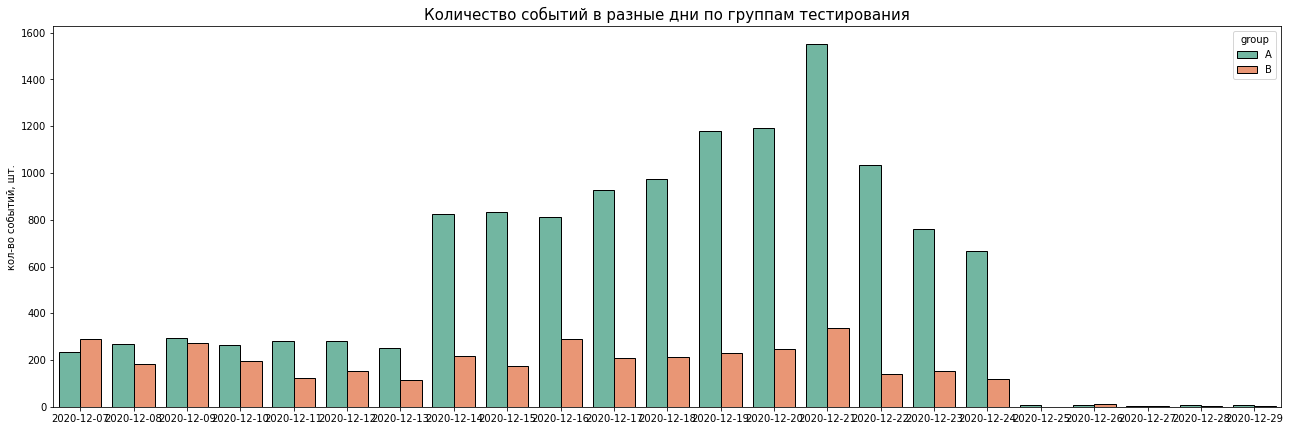

In [553]:
plt.figure(figsize = (22,7))

sns.barplot(data = events_dates, x = 'date', y = 'event_count', hue = 'group',
            palette = 'Set2', edgecolor = 'black')

plt.title('Количество событий в разные дни по группам тестирования', size = 15)
plt.xlabel('')
plt.ylabel('кол-во событий, шт.')


plt.show()

*Число событий по дням распределено неравномерно, всегда заметно преимущество группы А кроме самого первого дня, с течением времени кол-во событий группы А увеличивается еще больше.*

#### *Как меняется конверсия в воронке в выборках на разных этапах?*

In [554]:
# посмотрим на последовательность событий в воронке путём подсчета каждого события

display((participants_events.groupby('event_name', as_index = False)
                            .user_id
                            .count()
                            .rename(columns = {'user_id' : 'amount'})
                            .sort_values(by = 'amount', ascending = False)
                            .reset_index(drop = True)))

,event_name,amount
0,login,7401
1,product_page,4594
2,product_cart,2218
3,purchase,2141


*Последовательность событий в воронке: **login** >> **product_page** >> **product_card** >> **purchase**.*

In [555]:
# добавляем таблицу final_ab_new_users

participants_events = (participants_events.merge(final_ab_new_users[['user_id', 'first_date']],
                                                 how = 'left',
                                                 on = 'user_id'))

In [556]:
# преобразовываем тип данных

participants_events['date'] = pd.to_datetime(participants_events['date'])

# считаем разницу между регистрацией и событием
difference = (participants_events['date'] - participants_events['first_date']).dt.days
participants_events['difference'] = difference

# избавляемся от ненужных событий
participants_events = participants_events.query('difference < 14')

In [557]:
# считаем кол-во событий для группы А и конверсию

events_a = (participants_events.query('group == "A"')
                               .groupby('event_name', as_index = False)
                               .user_id
                               .nunique()
                               .rename(columns = {'user_id' : 'amount'})
                               .sort_values(by = 'amount', ascending = False)
                               .reset_index(drop = True))

events_a = events_a.reindex([0,1,3,2])
events_a['conversion'] = events_a['amount'] / events_a['amount'].max()

# считаем кол-во событий для группы B и конверсию

events_b = (participants_events.query('group == "B"')
                               .groupby('event_name', as_index = False)
                               .user_id
                               .nunique()
                               .rename(columns = {'user_id' : 'amount'})
                               .sort_values(by = 'amount', ascending = False)
                               .reset_index(drop = True))

events_b = events_b.reindex([0,1,3,2])
events_b['conversion'] = events_b['amount'] / events_b['amount'].max()

###

print("Группа А:")
display(events_a)

print("Группа B:")
display(events_b)


Группа А:


,event_name,amount,conversion
0,login,2082,1.000
1,product_page,1360,0.653
3,product_cart,631,0.303
2,purchase,652,0.313


Группа B:


,event_name,amount,conversion
0,login,705,1.000
1,product_page,397,0.563
3,product_cart,195,0.277
2,purchase,198,0.281


In [558]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A',
    y = list(events_a.event_name),
    x = list(events_a.amount),
    textinfo = "value+percent previous"))

fig.add_trace(go.Funnel(
    name = 'B',
    y = list(events_b.amount),
    x = list(events_b.amount),
    textinfo = "value+percent previous"))

fig.update_layout(
    title = {
        'text' : 'Конверсия событий пользователей по группам А и В',
        'x':0.5
    }
)

fig.show()

*Пользователи пропускают этап product_cart, по-видимому, товар можно купить без просмотра корзины. Конверсия группы А гораздо лучше конверсии группы B.*

***Итоги исследовательского анализа данных:***

- *Кол-во событий на пользователя в выборках распределены по-разному.*
- *Число событий по дням распределено неравномерно, всегда заметно преимущество группы А кроме самого первого дня, с течением времени кол-во событий группы А увеличивается еще больше.*
- *Последовательность событий в воронке: **login** >> **product_page** >> **product_card** >> **purchase**.*
- *Пользователи пропускают этап product_cart, по-видимому, товар можно купить без просмотра корзины. Конверсия группы А гораздо лучше конверсии группы B.*

---
### *Оценка результатов A/B-тестирования*

#### *Что можно сказать про результаты A/B-тестирования?*

*В группах разное кол-во пользователей, что может привести к искажению результатов a/b-теста, надо более ответственно к этому подходить, так как a/b-тест довольно дорогостоящий и растрачивать ресурсы неграмотно с разным кол-вом пользователей в группах крайне нежелательно.*


#### *Проверка статистической разницы долей z-критерием*

- ***H0*** - *разницы между долями нет, они одинаковые*
- ***H1*** - *разница между долями есть, они разные*

In [559]:
# объединяем 2 датасета в 1 для удобства

groups = events_a.merge(events_b, on = 'event_name', how = 'inner', suffixes = ('_a', '_b'))

# считаем уникальных участников теста

unique_a = participants_events.query('group == "A"').user_id.nunique()
unique_b = participants_events.query('group == "B"').user_id.nunique()

In [560]:
# функция для z-теста, так как будем его использовать для 4х событий

def z_test(success_1, success_2):
    
    # критический уровень значимости, учитываем поправку Бонферони и делим на 4
    alpha = .05 / 4
    
    successes = [success_1, success_2]
    trials = [unique_a, unique_b]
    

    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    difference = p1 - p2
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    if p_value < alpha:
        print('Принимаем H1. Разница между долями есть.')
    else:
        print('Не можем отвергнуть H0. Разница между долями нет.')

In [561]:
# проходимся по датасету и считаем p_value
# проходится циклом по массиву нежелательно, но так как датасет маленький, то допустимо

for index, row in groups.iterrows():
    print(f'z-тест для {row.event_name}:')
    z_test(row['amount_a'], row['amount_b'])
    print('')

z-тест для login:
Не можем отвергнуть H0. Разница между долями нет.

z-тест для product_page:
Принимаем H1. Разница между долями есть.

z-тест для product_cart:
Не можем отвергнуть H0. Разница между долями нет.

z-тест для purchase:
Не можем отвергнуть H0. Разница между долями нет.



***Итоги оценки результатов a/b-тестирования:***
- *Статистической разницы нет между выборками групп A и B для этапов login, product_cart и purchase.*
- *Статистическая разница есть в конверсии групп А и В для события product_page.*

---
### *Вывод*

***В этом исследовании было предоставлено 4 датасета для анализа a/b-теста и ТЗ. Было сделано и обнаружено следующее:***

- ***Предобработка данных***
    1. *Заменили типы данных в некоторых столбцах*
    2. *Дубликатов в датасетах не оказалось*
    3. *Пропуски были только в одном столбце, заполнили их нулями, чтобы не потерять данные*


- ***Оценка корректности проведения теста:***
    1. *Нашли пользователей, пересекающихся в обоих тестах, удалили их, удалили данные из ненужного теста*
    2. *Пользователей, попавших в обе группы не оказалось, но кол-во пользователей в группах сильно отличается*
    3. *Удалили лишних новых пользователей, которые добавлялись после дедлайна*
    4. *Также тест заканчивается раньше, чем было по ТЗ*
    5. *Кол-во участников меньше, чем по ТЗ*
    6. *Во время теста проводилось 2 маркетинговые компании, которые могли сильно повлиять на a/b-тест*


- ***Исследовательский анализ данных:***
    1. *Кол-во событий на пользователя в выборках распределены по-разному.*
    2. *Число событий по дням распределено неравномерно, всегда заметно преимущество группы А кроме самого первого дня, с течением времени кол-во событий группы А увеличивается еще больше.*
    3. *Последовательность событий в воронке: **login** >> **product_page** >> **product_card** >> **purchase**.*
    4. *Пользователи пропускают этап product_cart, по-видимому, товар можно купить без просмотра корзины. Конверсия группы А гораздо лучше конверсии группы B.*
    
    
- ***Итоги оценки результатов a/b-тестирования:***
    1. *Статистической разницы нет между выборками групп A и B для этапов login, product_cart и purchase.*
    2. *Статистическая разница есть в конверсии групп А и В для события product_page.*
    
***Было очень много несовпадений по ТЗ, разное кол-во пользователей в выборках, маркетинговые события во время теста, поэтому не стоит доверять полученным результатам и провести a/b-тест, подходящий по ТЗ с учтёнными замечаниями.***